# Daily Climate Time Series Data

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data?select=DailyDelhiClimateTrain.csv

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
raw1 = pd.read_csv('data/DailyDelhiClimateTrain.csv')

raw1

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [5]:
# Drop the last row from the DataFrame
raw1 = raw1.iloc[:-1]  

raw1.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [6]:
raw2 = pd.read_csv('data/DailyDelhiClimateTest.csv')

raw2

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [7]:
# Append raw2 to the end of raw1
raw = pd.concat([raw1, raw2], axis=0) 

raw

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [8]:
# Convert 'datetime' to datetime type
raw['date'] = pd.to_datetime(raw['date'])

# Set as datetime index
raw.set_index('date', inplace=True)                  

# Display
raw.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [9]:
raw.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-04-20,34.500,27.500000,5.562500,998.625000
2017-04-21,34.250,39.375000,6.962500,999.875000
2017-04-22,32.900,40.900000,8.890000,1001.600000
2017-04-23,32.875,27.500000,9.962500,1002.125000
2017-04-24,32.000,27.142857,12.157143,1004.142857


In [10]:
# Rename 'meantemp' to 'temp'
raw.rename(columns={'meantemp': 'temp'}, inplace=True)  

raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          1575 non-null   float64
 1   humidity      1575 non-null   float64
 2   wind_speed    1575 non-null   float64
 3   meanpressure  1575 non-null   float64
dtypes: float64(4)
memory usage: 61.5 KB


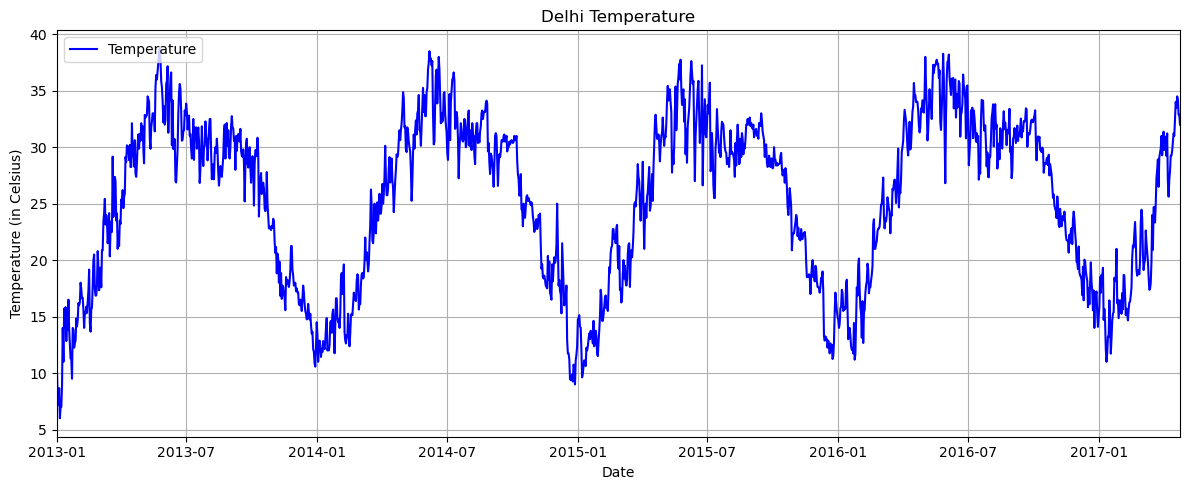

In [11]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw.index, raw['temp'], label='Temperature', color='blue')     

plt.title('Delhi Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

# SARIMA

### Split in Train & Test datasets

In [12]:
# Split the data
cutoff = pd.to_datetime("2017-01-01")

train = raw[raw.index < cutoff]
test = raw[raw.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (1461, 4)
Test shape: (114, 4)

                 temp   humidity  wind_speed  meanpressure
date                                                      
2016-12-27  16.850000  67.550000    8.335000   1017.200000
2016-12-28  17.217391  68.043478    3.547826   1015.565217
2016-12-29  15.238095  87.857143    6.000000   1016.904762
2016-12-30  14.095238  89.666667    6.266667   1017.904762
2016-12-31  15.052632  87.000000    7.325000   1016.100000

                 temp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [13]:
tem_series = train['temp']

len(tem_series)

1461

### Find 'd'

In [14]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(tem_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.1556, p-value = 0.2228
d = 1 | ADF Statistic = -16.5204, p-value = 0.0000

Non-seasonal differencing term (d): 1


### Find 'S'

In [15]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(tem_series)

Detected Seasonal Period: S = 365


### Check possible S's

In [16]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(tem_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 365.25 (Frequency = 0.00274), Magnitude = 6822.72
2. Period = 182.62 (Frequency = 0.00548), Magnitude = 2250.49
3. Period = 1461.0 (Frequency = 0.00068), Magnitude = 719.86
4. Period = 208.71 (Frequency = 0.00479), Magnitude = 499.21
5. Period = 730.5 (Frequency = 0.00137), Magnitude = 495.12
6. Period = 121.75 (Frequency = 0.00821), Magnitude = 452.88
7. Period = 37.46 (Frequency = 0.02669), Magnitude = 369.89
8. Period = 292.2 (Frequency = 0.00342), Magnitude = 349.1
9. Period = 91.31 (Frequency = 0.01095), Magnitude = 325.01
10. Period = 35.63 (Frequency = 0.02806), Magnitude = 295.31


### Find 'D'

In [17]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [7, 30, 52, 365]:

    D = determine_seasonal_D(tem_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0
Seasonal differencing term (D) for 365: 2


In [18]:
print('                Canova-Hansen test:', nsdiffs(tem_series, m=365, test='ch'))
print('Osborn-Chui-Smith-Birchenhall test:', nsdiffs(tem_series, m=365, test='ocsb'))

                Canova-Hansen test: 2
Osborn-Chui-Smith-Birchenhall test: 0


### Seasonal Decomposition

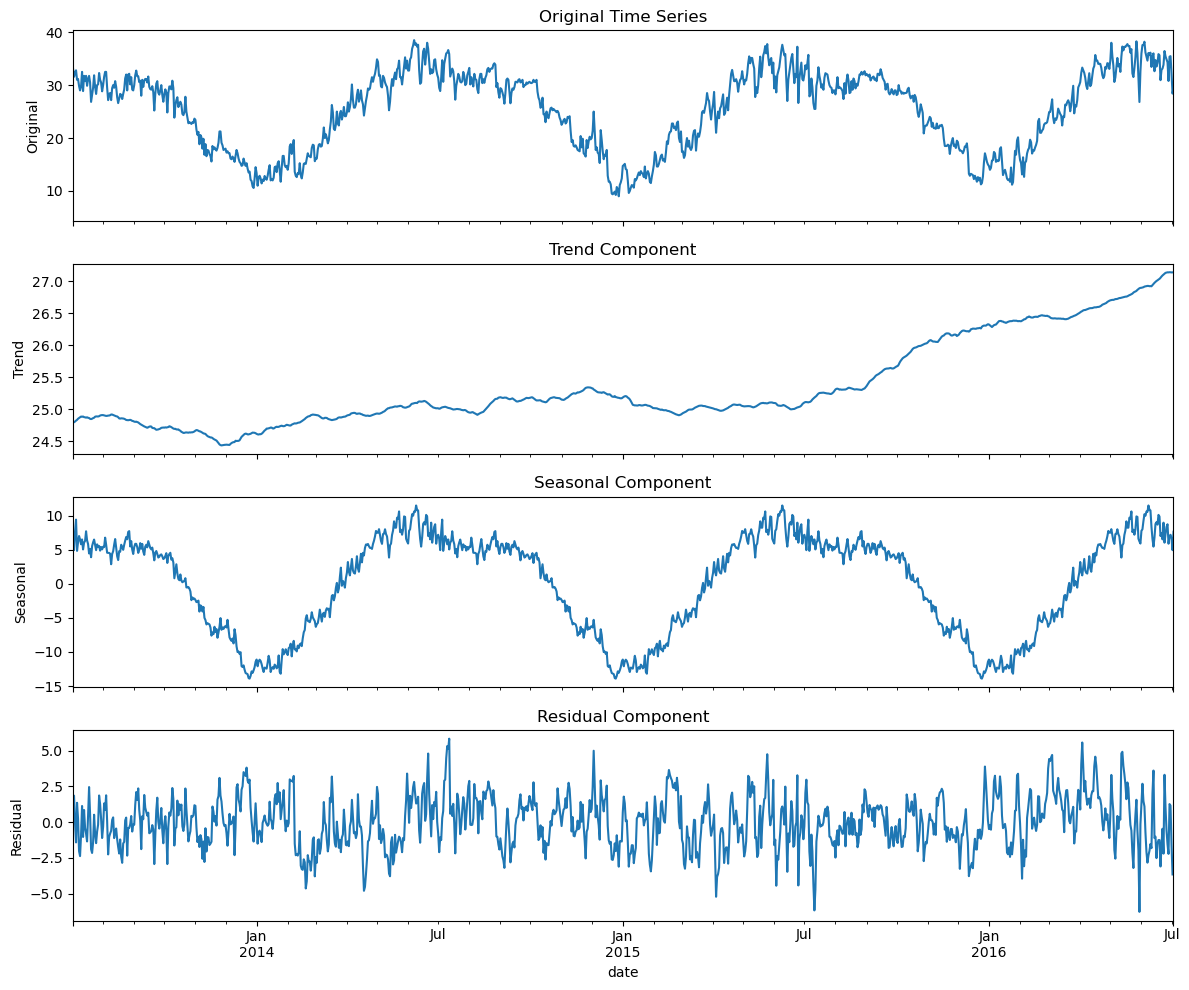

In [19]:
result = seasonal_decompose(tem_series, model='aditive', period=365)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

Approximate equation:
 y(t) = 25.51 + -9.32 * cos(2 * pi * 0.00274 * t) + -0.61 * sin(2 * pi * 0.00274 * t) + -2.61 * cos(2 * pi * 0.00548 * t) + -1.64 * sin(2 * pi * 0.00548 * t) + 0.54 * cos(2 * pi * 0.00068 * t) + -0.83 * sin(2 * pi * 0.00068 * t) + -0.20 * cos(2 * pi * 0.00479 * t) + -0.65 * sin(2 * pi * 0.00479 * t) + 0.05 * cos(2 * pi * 0.00137 * t) + -0.68 * sin(2 * pi * 0.00137 * t) + 0.00 * cos(2 * pi * 0.00821 * t) + 0.62 * sin(2 * pi * 0.00821 * t) + 0.21 * cos(2 * pi * 0.02669 * t) + -0.46 * sin(2 * pi * 0.02669 * t) + 0.46 * cos(2 * pi * 0.00342 * t) + -0.13 * sin(2 * pi * 0.00342 * t) + -0.12 * cos(2 * pi * 0.01095 * t) + -0.43 * sin(2 * pi * 0.01095 * t) + 0.12 * cos(2 * pi * 0.02806 * t) + -0.39 * sin(2 * pi * 0.02806 * t) + -0.32 * cos(2 * pi * 0.04449 * t) + -0.22 * sin(2 * pi * 0.04449 * t) + -0.33 * cos(2 * pi * 0.01643 * t) + -0.19 * sin(2 * pi * 0.01643 * t) + -0.36 * cos(2 * pi * 0.02396 * t) + -0.04 * sin(2 * pi * 0.02396 * t) + 0.33 * cos(2 * pi * 0.06160 * t) 

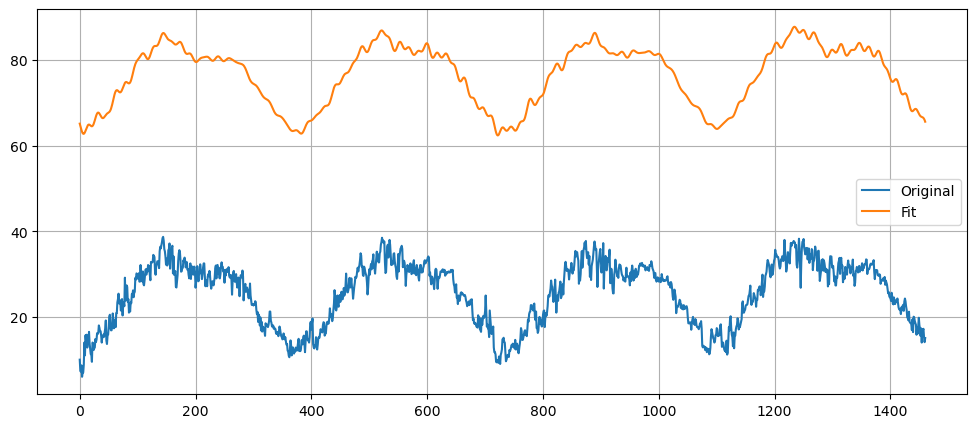

In [20]:
# Data
N = len(tem_series)     # Number of days
t = np.arange(N)        # Indice of days
S = 365                 # Sazonality

# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N)

# Positive frequencies
positive_freqs = frequencies[:N//2]
fourier_positive = fourier[:N//2]

# Find the dominant frequencies (relative to S=365)
K = 16                                                             # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N          # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N         # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)

# Reconstruct the adjusted series
y_fit = np.zeros(N)
y_fit += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit += (2 * np.real(amp) / N) * np.cos(2 * np.pi * freq * t) + (-2 * np.imag(amp) / N) * np.sin(2 * np.pi * freq * t)

# Plot Graph
plt.figure(figsize=(12, 5))
plt.plot(t, tem_series, label='Original')
plt.plot(t, y_fit, label='Fit')
plt.legend()
plt.grid(True)
plt.show()

### Fourier Transformation, K=16

Approximate equation:
 y(t) = 25.51 + -9.32 * cos(2 * pi * 0.00274 * t) + -0.61 * sin(2 * pi * 0.00274 * t) + -2.61 * cos(2 * pi * 0.00548 * t) + -1.64 * sin(2 * pi * 0.00548 * t) + 0.54 * cos(2 * pi * 0.00068 * t) + -0.83 * sin(2 * pi * 0.00068 * t) + -0.20 * cos(2 * pi * 0.00479 * t) + -0.65 * sin(2 * pi * 0.00479 * t) + 0.05 * cos(2 * pi * 0.00137 * t) + -0.68 * sin(2 * pi * 0.00137 * t) + 0.00 * cos(2 * pi * 0.00821 * t) + 0.62 * sin(2 * pi * 0.00821 * t) + 0.21 * cos(2 * pi * 0.02669 * t) + -0.46 * sin(2 * pi * 0.02669 * t) + 0.46 * cos(2 * pi * 0.00342 * t) + -0.13 * sin(2 * pi * 0.00342 * t) + -0.12 * cos(2 * pi * 0.01095 * t) + -0.43 * sin(2 * pi * 0.01095 * t) + 0.12 * cos(2 * pi * 0.02806 * t) + -0.39 * sin(2 * pi * 0.02806 * t) + -0.32 * cos(2 * pi * 0.04449 * t) + -0.22 * sin(2 * pi * 0.04449 * t) + -0.33 * cos(2 * pi * 0.01643 * t) + -0.19 * sin(2 * pi * 0.01643 * t) + -0.36 * cos(2 * pi * 0.02396 * t) + -0.04 * sin(2 * pi * 0.02396 * t) + 0.33 * cos(2 * pi * 0.06160 * t) 

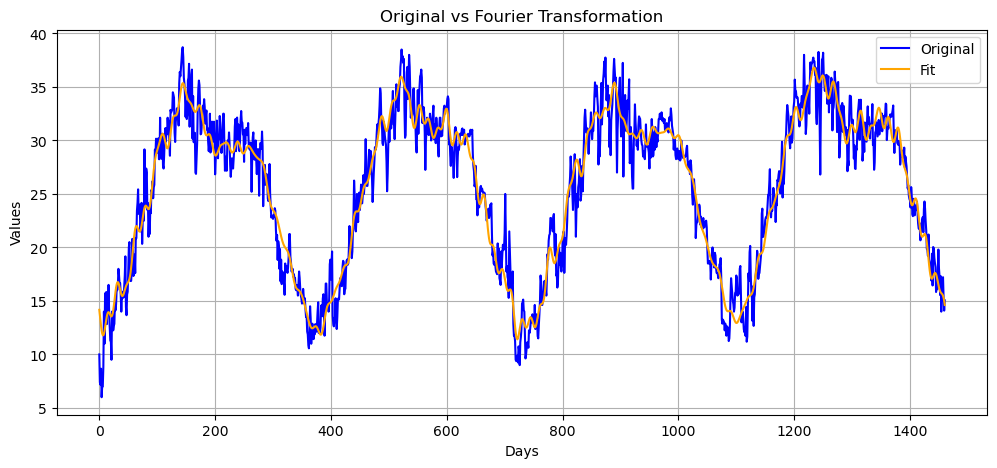

Mean Original: 25.506126761617864
Mean Adjusted: 25.506126761617868


In [21]:
# Data
N = len(tem_series)     # Number of days
t = np.arange(N)        # Index of days
S = 365                 # Seasonality

# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N)

# Positive frequencies
positive_freqs = frequencies[:N//2]
fourier_positive = fourier[:N//2]

# Find the dominant frequencies (relative to S=365)
K = 16                                                             # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N          # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N         # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)

# Reconstruct the adjusted series
y_fit = np.zeros(N)
y_fit += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit += (2 * np.real(amp) / N) * np.cos(2 * np.pi * freq * t) + (-2 * np.imag(amp) / N) * np.sin(2 * np.pi * freq * t)

# Correct the vertical offset
offset = np.mean(y_fit) - np.mean(tem_series)
y_fit_corrected = y_fit - offset

# Plot Graph
plt.figure(figsize=(12, 5))
plt.plot(t, tem_series, label='Original', color='blue')
plt.plot(t, y_fit_corrected, label='Fit', color='orange')
plt.legend()
plt.grid(True)
plt.title('Original vs Fourier Transformation')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

print("Mean Original:", np.mean(tem_series))
print("Mean Adjusted:", np.mean(y_fit_corrected))

### Fourier Transformation, K=2 (Sine Projection, S=365)

Approximate equation:
 y(t) = 25.51 + -9.32 * cos(2 * pi * 0.00274 * t) + -0.61 * sin(2 * pi * 0.00274 * t)



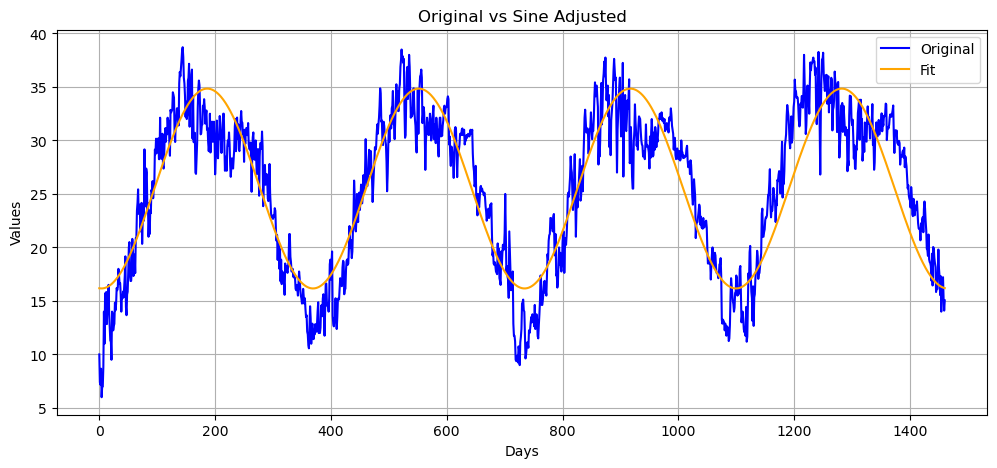

Mean Original: 25.506126761617864
Mean Adjusted: 25.506126761617868


In [22]:
# Data
N = len(tem_series)     # Number of days
t = np.arange(N)        # Index of days
S = 365                 # Seasonality

# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N)

# Positive frequencies
positive_freqs = frequencies[:N//2]
fourier_positive = fourier[:N//2]

# Find the dominant frequencies (relative to S=365)
K = 2                                                             # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N          # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N         # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)
print()

# Reconstruct the adjusted series
y_fit = np.zeros(N)
y_fit += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit += (2 * np.real(amp) / N) * np.cos(2 * np.pi * freq * t) + (-2 * np.imag(amp) / N) * np.sin(2 * np.pi * freq * t)

# Correct the vertical offset
offset = np.mean(y_fit) - np.mean(tem_series)
y_fit_corrected = y_fit - offset

# Plot Graph
plt.figure(figsize=(12, 5))
plt.plot(t, tem_series, label='Original', color='blue')
plt.plot(t, y_fit_corrected, label='Fit', color='orange')
plt.legend()
plt.grid(True)
plt.title('Original vs Sine Adjusted')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

print("Mean Original:", np.mean(tem_series))
print("Mean Adjusted:", np.mean(y_fit_corrected))

### Fourier Transformation, K=4 (S=365): Exogenous Variable

Approximate equation:
 y(t) = 25.51 + -9.32 * cos(2 * pi * 0.00274 * t) + -0.61 * sin(2 * pi * 0.00274 * t) + -2.61 * cos(2 * pi * 0.00548 * t) + -1.64 * sin(2 * pi * 0.00548 * t) + 0.54 * cos(2 * pi * 0.00068 * t) + -0.83 * sin(2 * pi * 0.00068 * t)



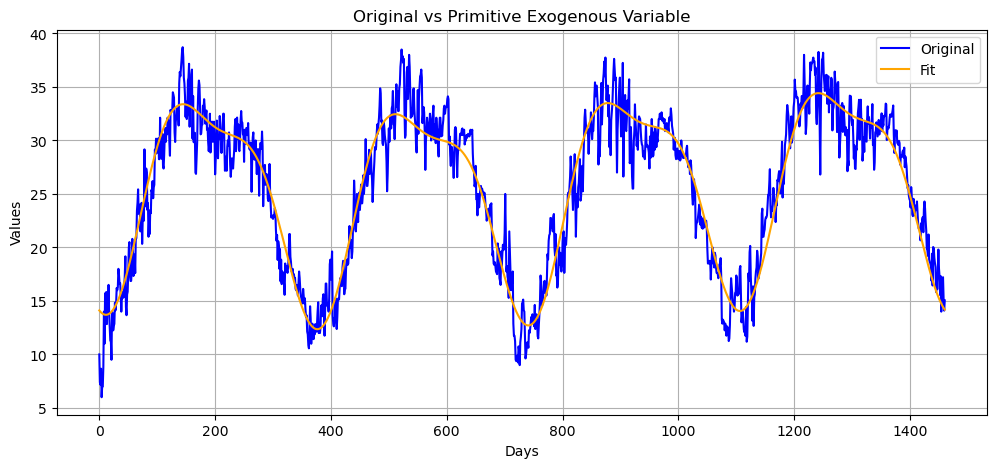

Mean Original: 25.506126761617864
Mean Adjusted: 25.506126761617864


In [23]:
# Data
N = len(tem_series)     # Number of days
t = np.arange(N)        # Index of days
S = 365                 # Seasonality

# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N)

# Positive frequencies
positive_freqs = frequencies[:N//2]
fourier_positive = fourier[:N//2]

# Find the dominant frequencies (relative to S=365)
K = 4                                                              # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N          # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N         # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)
print()

# Reconstruct the adjusted series
y_fit = np.zeros(N)
y_fit += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit += (2 * np.real(amp) / N) * np.cos(2 * np.pi * freq * t) + (-2 * np.imag(amp) / N) * np.sin(2 * np.pi * freq * t)

# Correct the vertical offset
offset = np.mean(y_fit) - np.mean(tem_series)
y_fit_corrected = y_fit - offset

# Plot Graph
plt.figure(figsize=(12, 5))
plt.plot(t, tem_series, label='Original', color='blue')
plt.plot(t, y_fit_corrected, label='Fit', color='orange')
plt.legend()
plt.grid(True)
plt.title('Original vs Primitive Exogenous Variable')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

print("Mean Original:", np.mean(tem_series))
print("Mean Adjusted:", np.mean(y_fit_corrected))

In [24]:
y_fit_corrected

array([14.11385335, 14.04625681, 13.98456266, ..., 14.35135784,
       14.26647825, 14.18728456])

In [25]:
len(y_fit_corrected)

1461

### It is necessary extrapolate more steps based on test size

Approximate equation:
 y(t) = 25.51 + -9.32 * cos(2 * pi * 0.00274 * t) + -0.61 * sin(2 * pi * 0.00274 * t) + -2.61 * cos(2 * pi * 0.00548 * t) + -1.64 * sin(2 * pi * 0.00548 * t) + 0.54 * cos(2 * pi * 0.00068 * t) + -0.83 * sin(2 * pi * 0.00068 * t)

Length of fourier_train: 1461
Length of fourier_test: 114


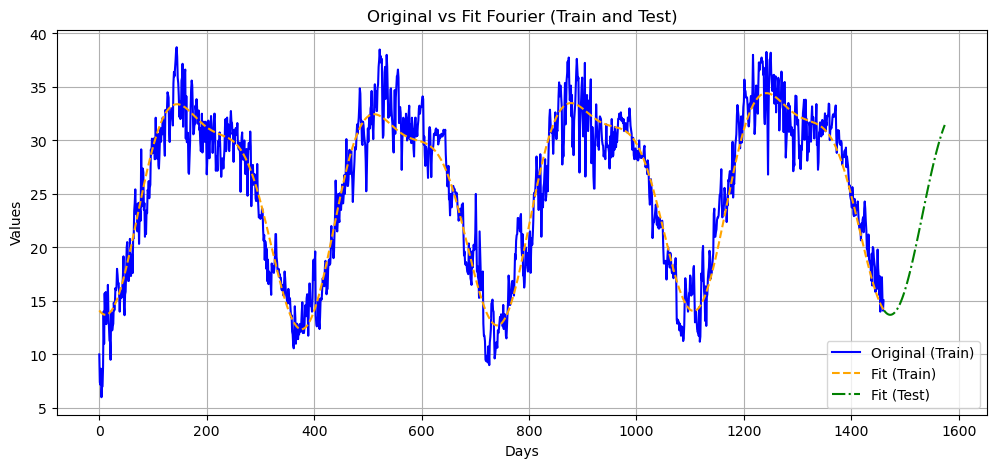

In [26]:
# Data for training
N_train = train.shape[0]      # Number of days in training
t_train = np.arange(N_train)  # Index of days
S = 365                       # Seasonality

# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N_train)

# Positive frequencies
positive_freqs = frequencies[:N_train//2]
fourier_positive = fourier[:N_train//2]

# Find the dominant frequencies (relative to S=365)
K = 4                                                              # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N_train    # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N_train   # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)
print()

# Reconstruct the adjusted series for training
y_fit_train = np.zeros(N_train)
y_fit_train += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit_train += (2 * np.real(amp) / N_train) * np.cos(2 * np.pi * freq * t_train) + (-2 * np.imag(amp) / N_train) * np.sin(2 * np.pi * freq * t_train)

# Correct the vertical offset
offset = np.mean(y_fit_train) - np.mean(tem_series)
y_fit_corrected_train = y_fit_train - offset

# Extrapolate for test set
N_test = test.shape[0]
t_test = np.arange(N_train, N_train + N_test)  # New time indices for test
y_fit_test = np.zeros(N_test)
y_fit_test += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit_test += (2 * np.real(amp) / N_train) * np.cos(2 * np.pi * freq * t_test) + (-2 * np.imag(amp) / N_train) * np.sin(2 * np.pi * freq * t_test)

# Assign to fourier_train and fourier_test
fourier_train = y_fit_corrected_train
fourier_test = y_fit_test - offset  # Apply the same offset for consistency

# Print lengths
print("Length of fourier_train:", len(fourier_train))
print("Length of fourier_test:", len(fourier_test))

# Optional: Plot to verify
plt.figure(figsize=(12, 5))
plt.plot(t_train, tem_series, label='Original (Train)', color='blue')
plt.plot(t_train, fourier_train, label='Fit (Train)', color='orange', linestyle='--')
plt.plot(t_test, fourier_test, label='Fit (Test)', color='green', linestyle='-.')
plt.legend()
plt.grid(True)
plt.title('Original vs Fit Fourier (Train and Test)')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

In [27]:
train['Fourier'] = fourier_train
test['Fourier'] = fourier_test
#train['Real']= y_fit_corrected

train.head()

,temp,humidity,wind_speed,meanpressure,Fourier
date,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,14.113853
2013-01-02,7.400000,92.000000,2.980000,1017.800000,14.046257
2013-01-03,7.166667,87.000000,4.633333,1018.666667,13.984563
2013-01-04,8.666667,71.333333,1.233333,1017.166667,13.928834
2013-01-05,6.000000,86.833333,3.700000,1016.500000,13.879130


In [28]:
test.head()

,temp,humidity,wind_speed,meanpressure,Fourier
date,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,14.113853
2017-01-02,18.500000,77.222222,2.894444,1018.277778,14.046257
2017-01-03,17.111111,81.888889,4.016667,1018.333333,13.984563
2017-01-04,18.700000,70.050000,4.545000,1015.700000,13.928834
2017-01-05,18.388889,74.944444,3.300000,1014.333333,13.879130


### Model

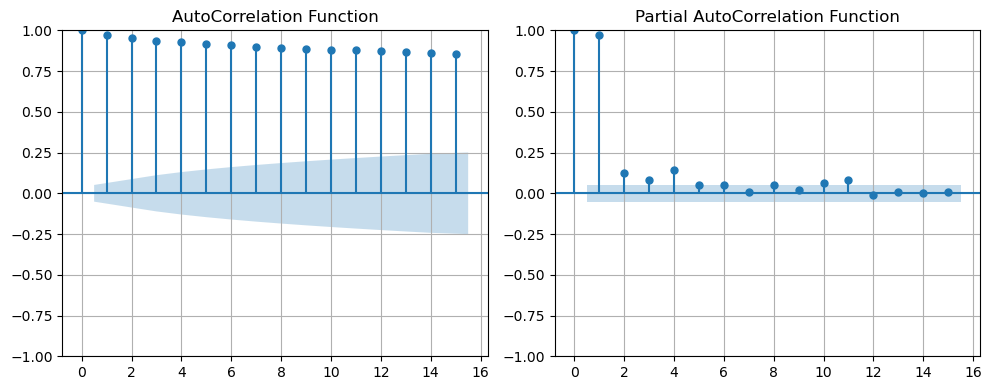

In [29]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(tem_series, lagsn=15)

In [30]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_31n = SARIMAX(endog=train['temp'],            # Time series data
                    order=(3, 1, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 0, 365),  # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_31n = model_31n.fit()

# Display summary of the model
print(model_fit_31n.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 temp   No. Observations:                 1461
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 365)   Log Likelihood               -2036.276
Date:                              Mon, 26 May 2025   AIC                           4088.552
Time:                                      10:29:55   BIC                           4128.519
Sample:                                  01-01-2013   HQIC                          4103.677
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2588      0.269     -0.962      0.336      -0.786       0.268
ar.L2          0.35

In [31]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_31n)

ar.L1 coefficient: -0.2588
ar.L1 95% CI: (-0.7857, 0.2682)
ar.L1 p-value: 0.3358
ar.L1 is statistically IRRELEVANT in the model.

ar.L3 coefficient: -0.0330
ar.L3 95% CI: (-0.3618, 0.2958)
ar.L3 p-value: 0.8440
ar.L3 is statistically IRRELEVANT in the model.

ma.L1 coefficient: 0.0877
ma.L1 95% CI: (-0.4438, 0.6191)
ma.L1 p-value: 0.7464
ma.L1 is statistically IRRELEVANT in the model.

ma.L3 coefficient: -0.0975
ma.L3 95% CI: (-0.5124, 0.3174)
ma.L3 p-value: 0.6451
ma.L3 is statistically IRRELEVANT in the model.

ar.S.L365 coefficient: 0.0463
ar.S.L365 95% CI: (-0.0044, 0.0970)
ar.S.L365 p-value: 0.0733
ar.S.L365 is statistically IRRELEVANT in the model.



In [32]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_000 = SARIMAX(endog=train['temp'],            # Time series data
                    exog=train[['Fourier']],        # Seasonal component
                    order=(3, 1, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 0),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_000 = model_000.fit()

# Display summary of the model
print(model_fit_000.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1461
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2691.168
Date:                Mon, 26 May 2025   AIC                           5398.337
Time:                        10:29:56   BIC                           5440.604
Sample:                    01-01-2013   HQIC                          5414.107
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fourier        0.9935      0.024     41.657      0.000       0.947       1.040
ar.L1         -0.6298      0.161     -3.901      0.000      -0.946      -0.313
ar.L2          0.3017      0.066      4.586      0.0

In [33]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_212 = SARIMAX(endog=train['temp'],            # Time series data
                    exog=train[['Fourier']],        # Seasonal component
                    order=(2, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 365),  # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_212 = model_212.fit()

# Display summary of the model
print(model_fit_212.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1461
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2695.441
Date:                Mon, 26 May 2025   AIC                           5402.883
Time:                        10:29:57   BIC                           5434.588
Sample:                    01-01-2013   HQIC                          5414.711
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fourier        0.9944      0.024     41.807      0.000       0.948       1.041
ar.L1         -0.2334      0.048     -4.880      0.000      -0.327      -0.140
ar.L2          0.6648      0.032     21.091      0.0

In [34]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_212)

ma.L1 coefficient: -0.0610
ma.L1 95% CI: (-0.1536, 0.0315)
ma.L1 p-value: 0.1963
ma.L1 is statistically IRRELEVANT in the model.



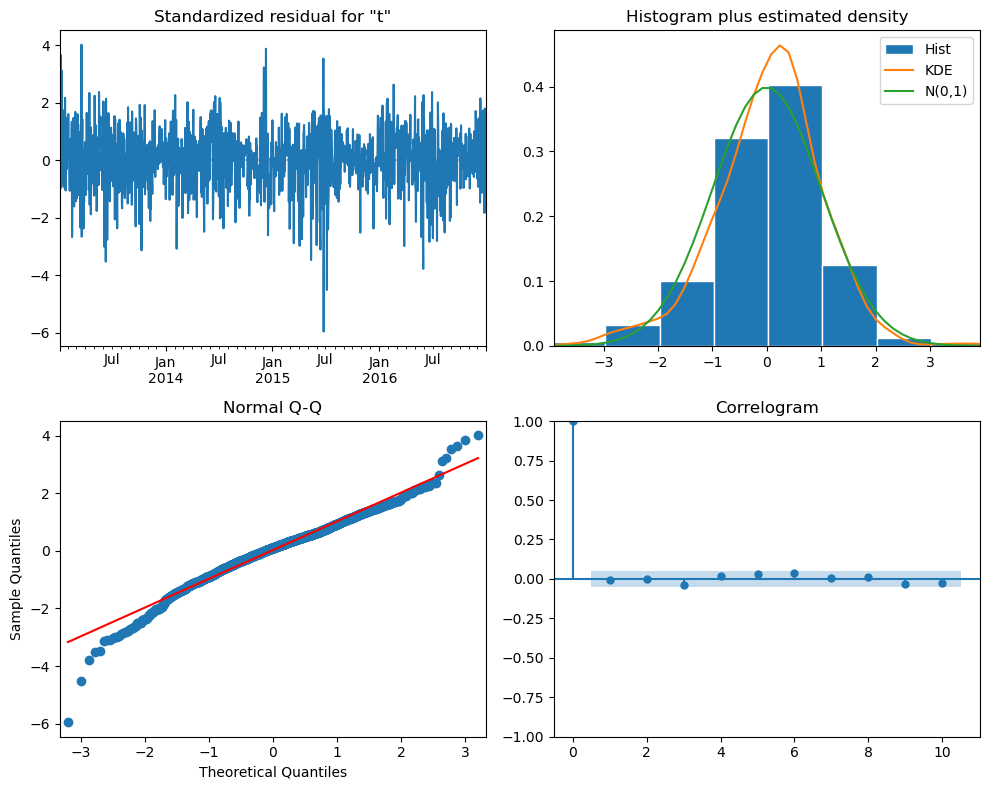

In [35]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_212.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [36]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_212.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.008655,0.925877
2,0.009520,0.995251
3,2.149562,0.541951
4,2.691739,0.610661
5,4.456854,0.485677
6,5.854455,0.439690
7,5.862440,0.555900
8,5.977033,0.649805
9,7.614562,0.573406
10,9.093511,0.523253


In [37]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9981
Conclusion: No significant autocorrelation.


In [38]:
# Must match the structure of training exog
exog_test_S = test[['Fourier']] 

# Forecast the next Time points with exogenous inputs
forecast_S = model_fit_212.get_forecast(steps=test.shape[0], exog=exog_test_S)

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values
test['Error S'] = test['Forecast S'] - test['temp']
test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,temp,humidity,wind_speed,meanpressure,Fourier,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
date,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,14.113853,15.045866,-0.867177,12.033719,18.058013
2017-01-02,18.500000,77.222222,2.894444,1018.277778,14.046257,14.974978,-3.525022,11.288452,18.661505
2017-01-03,17.111111,81.888889,4.016667,1018.333333,13.984563,14.958535,-2.152576,10.950778,18.966292
2017-01-04,18.700000,70.050000,4.545000,1015.700000,13.928834,14.890200,-3.809800,10.731105,19.049295
2017-01-05,18.388889,74.944444,3.300000,1014.333333,13.879130,14.873644,-3.515245,10.628312,19.118975


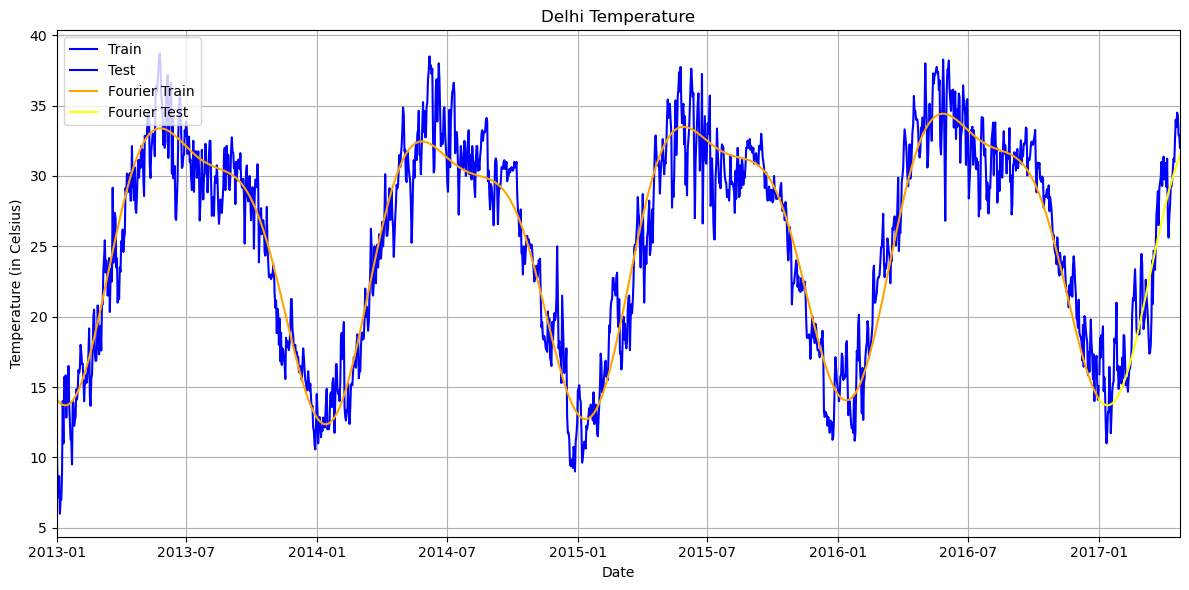

In [39]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(train.index, train['temp'], label='Train', color='blue')                  # Train
plt.plot(test.index, test['temp'], label='Test', color='blue')                     # Test
plt.plot(train.index, train['Fourier'], label='Fourier Train', color='orange')     # Fourier Train
plt.plot(test.index, test['Fourier'], label='Fourier Test', color='yellow')        # Fourier Test

plt.title('Delhi Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

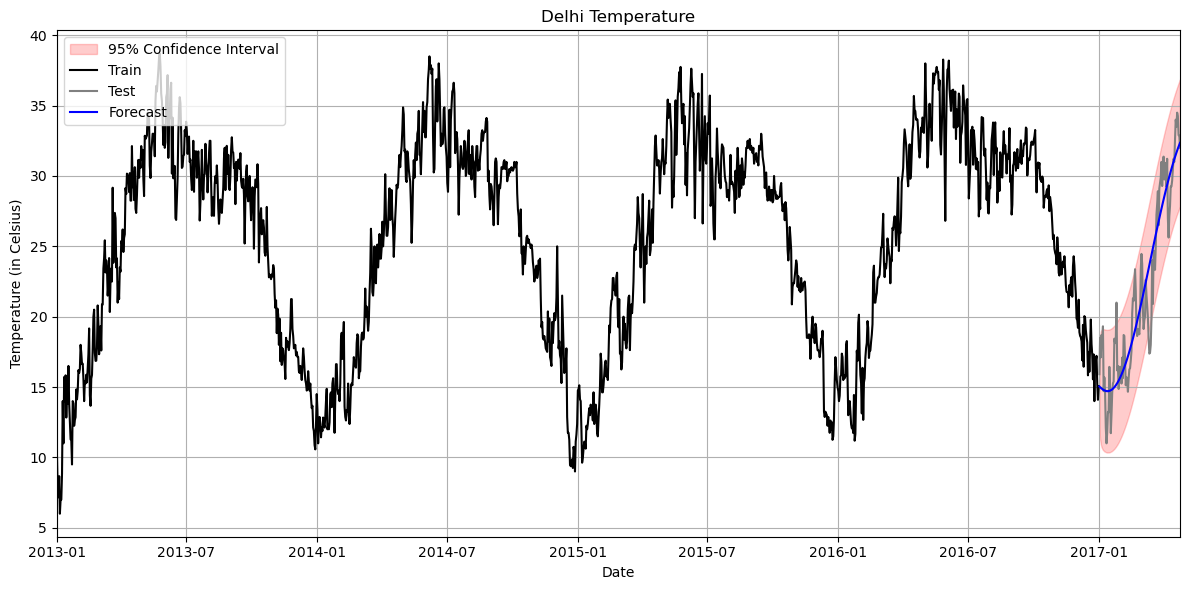

In [40]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Delhi Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

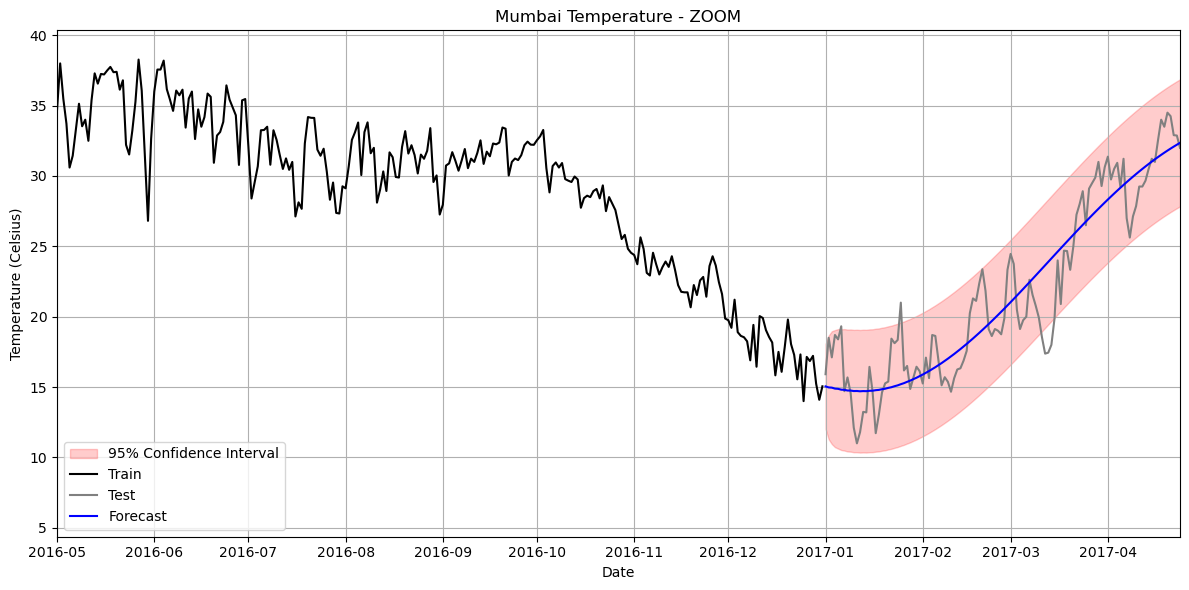

In [41]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2016-05-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=3)                                             
plt.tight_layout()                                       
plt.show();

    Alternative:

```Python
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=2)  # Annual cycle
dp = DeterministicProcess(index=train.index,
                          constant=True,
                          order=0,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X_fourier = dp.in_sample()

model = SARIMAX(train['pollution'], exog=X_fourier, order=(2,1,2), seasonal_order=(1,0,1,365))
```

# SARIMAX Model with Exogenous Variables

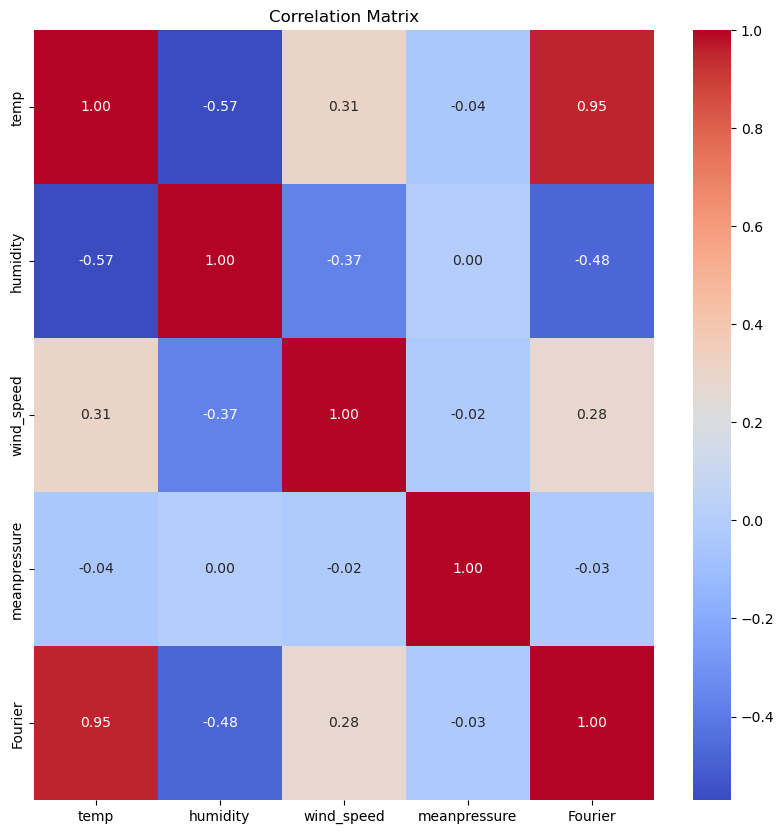

In [42]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [43]:
# Identify columns where the first row value is >= 0.5 or <= -0.5
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[0] >= 0.30, 
                                                  c_matrix.iloc[0] <= -0.30)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'temp']

# Show the result
print(filtered_columns)

['humidity', 'wind_speed', 'Fourier']


In [44]:
# Create candidates dataframe
candidates = train[['humidity', 'Fourier', 'wind_speed']]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

             VIF         Interpretation
Feature                                
humidity    3.34  Not Multicollinearity
Fourier     2.73  Not Multicollinearity
wind_speed  1.89  Not Multicollinearity

Correlation:
            humidity  Fourier  wind_speed
humidity        1.00    -0.90       -0.82
Fourier        -0.90     1.00        0.49
wind_speed     -0.82     0.49        1.00


    Candidates based on VIF: 'humidity', 'Fourier', 'wind_speed'.

### Gauger Test

In [46]:
def prepare_granger_data_multi(y, X, d=0, D=0, S=12):

    # Apply seasonal differencing D times to y and all columns in X
    for _ in range(D):
        y = y.diff(S)
        X = X.diff(S)

    # Apply regular differencing d times
    for _ in range(d):
        y = y.diff()
        X = X.diff()

    # Drop missing values
    y = y.dropna()
    X = X.dropna()

    # Concatenate and align
    df = pd.concat([y] + [X[col] for col in X.columns], axis=1).dropna()
    df.columns = [y.name] + list(X.columns)

    return df


# Assume y is a Series and X is a DataFrame with multiple exogenous variables
y = train['temp']
X = train[['humidity', 'wind_speed', 'meanpressure', 'Fourier']]

# Prepare data
df_granger = prepare_granger_data_multi(y, X, d=1, D=0, S=365)

# Test each exogenous variable separately
from statsmodels.tsa.stattools import grangercausalitytests

for col in X.columns:
    print(f"\nTesting if {col} Granger-causes {y.name}")
    #grangercausalitytests(df_granger[[y.name, col]], maxlag=7, verbose=True)


Testing if humidity Granger-causes temp

Testing if wind_speed Granger-causes temp

Testing if meanpressure Granger-causes temp

Testing if Fourier Granger-causes temp


In [47]:
from statsmodels.tsa.stattools import grangercausalitytests

def summarize_granger_results(df, target_col, maxlag=7, alpha=0.05):

    results = []

    # Loop through all exogenous variables
    for col in df.columns:
        if col == target_col:
            continue  # skip the dependent variable

        # Run Granger test
        test_result = grangercausalitytests(df[[target_col, col]], maxlag=maxlag, verbose=False)

        # Extract p-values from ssr_chi2test for each lag
        p_values = [round(test_result[lag][0]['ssr_chi2test'][1], 4) for lag in range(1, maxlag+1)]

        # Find best (lowest) p-value and corresponding lag
        min_p = min(p_values)
        best_lag = p_values.index(min_p) + 1  # lags start at 1

        # Flag if variable Granger-causes the target
        granger_causes = 'Yes' if min_p < alpha else 'No'

        results.append({
            'Exogenous Variable': col,
            'Min p-value': min_p,
            'Best Lag': best_lag,
            'Granger-Causes ' + target_col: granger_causes
        })

    # Convert to DataFrame and set index
    summary_df = pd.DataFrame(results)
    summary_df.set_index('Exogenous Variable', inplace=True)

    return summary_df

# df_granger deve conter target + exógenas
summary = summarize_granger_results(df_granger, target_col='temp', maxlag=7)
summary

,Min p-value,Best Lag,Granger-Causes temp
Exogenous Variable,,,
humidity,0.1117,2,No
wind_speed,0.0021,5,Yes
meanpressure,0.4704,1,No
Fourier,0.0000,3,Yes


In [48]:
# Multiple column selection
exog_data = train[['humidity','wind_speed','Fourier']]  

# Target variable selection
endog_data = train['temp']        

In [49]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(2, 1, 2),               
                  seasonal_order=(0, 0, 0, 365),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1461
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2310.056
Date:                Mon, 26 May 2025   AIC                           4636.113
Time:                        10:29:59   BIC                           4678.386
Sample:                    01-01-2013   HQIC                          4651.884
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1354      0.003    -38.843      0.000      -0.142      -0.129
wind_speed    -0.0274      0.006     -4.273      0.000      -0.040      -0.015
Fourier        0.7556      0.056     13.543      0.0

In [50]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

ar.L2 coefficient: -0.1834
ar.L2 95% CI: (-0.4573, 0.0906)
ar.L2 p-value: 0.1896
ar.L2 is statistically IRRELEVANT in the model.

ma.L2 coefficient: 0.0664
ma.L2 95% CI: (-0.2801, 0.4129)
ma.L2 p-value: 0.7071
ma.L2 is statistically IRRELEVANT in the model.



In [51]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(1, 1, 1),               
                  seasonal_order=(0, 0, 0, 365),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1461
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2323.019
Date:                Mon, 26 May 2025   AIC                           4658.038
Time:                        10:30:00   BIC                           4689.747
Sample:                    01-01-2013   HQIC                          4669.867
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1314      0.003    -42.009      0.000      -0.138      -0.125
wind_speed    -0.0293      0.007     -4.417      0.000      -0.042      -0.016
Fourier        0.7751      0.050     15.407      0.0

In [52]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

All variables are statistically relevant.


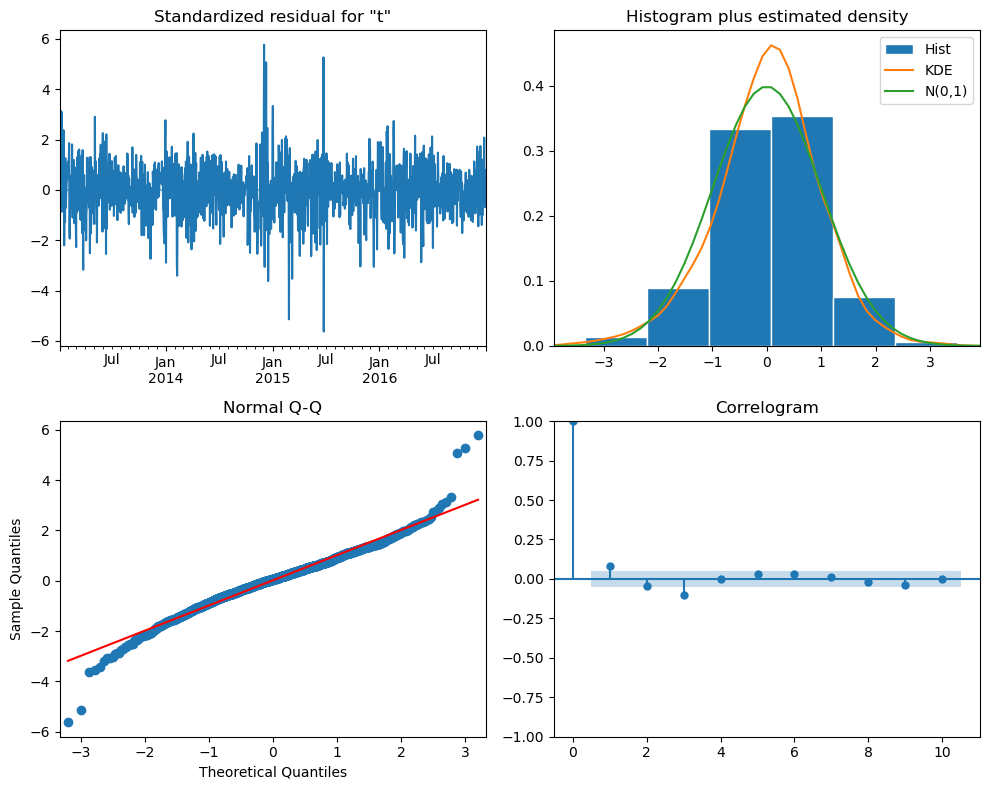

In [53]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [54]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,3.949624,0.046882
2,6.387376,0.041020
3,19.935322,0.000175
4,19.948650,0.000511
5,21.702450,0.000596
6,22.933630,0.000819
7,22.955189,0.001736
8,22.957380,0.003419
9,26.522956,0.001677
10,26.759199,0.002843


In [55]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.8483
Conclusion: No significant autocorrelation.


In [56]:
# Must match the structure of training exog
exog_test_M = test[['humidity','wind_speed','Fourier']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['temp']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,temp,humidity,wind_speed,meanpressure,Fourier,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date,,,,,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,14.113853,15.045866,-0.867177,12.033719,18.058013,15.003317,-0.909726,12.671341,17.335293
2017-01-02,18.500000,77.222222,2.894444,1018.277778,14.046257,14.974978,-3.525022,11.288452,18.661505,15.879751,-2.620249,12.903296,18.856207
2017-01-03,17.111111,81.888889,4.016667,1018.333333,13.984563,14.958535,-2.152576,10.950778,18.966292,15.035266,-2.075845,11.705367,18.365165
2017-01-04,18.700000,70.050000,4.545000,1015.700000,13.928834,14.890200,-3.809800,10.731105,19.049295,16.421544,-2.278456,12.872012,19.971076
2017-01-05,18.388889,74.944444,3.300000,1014.333333,13.879130,14.873644,-3.515245,10.628312,19.118975,15.693849,-2.695040,11.996732,19.390965


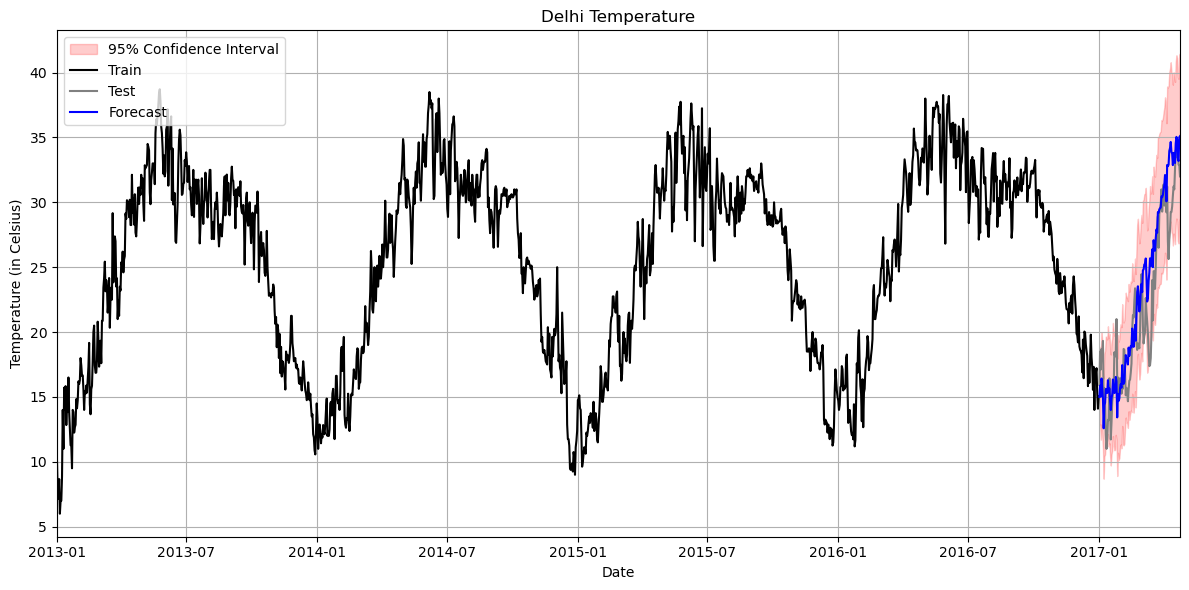

In [57]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Delhi Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

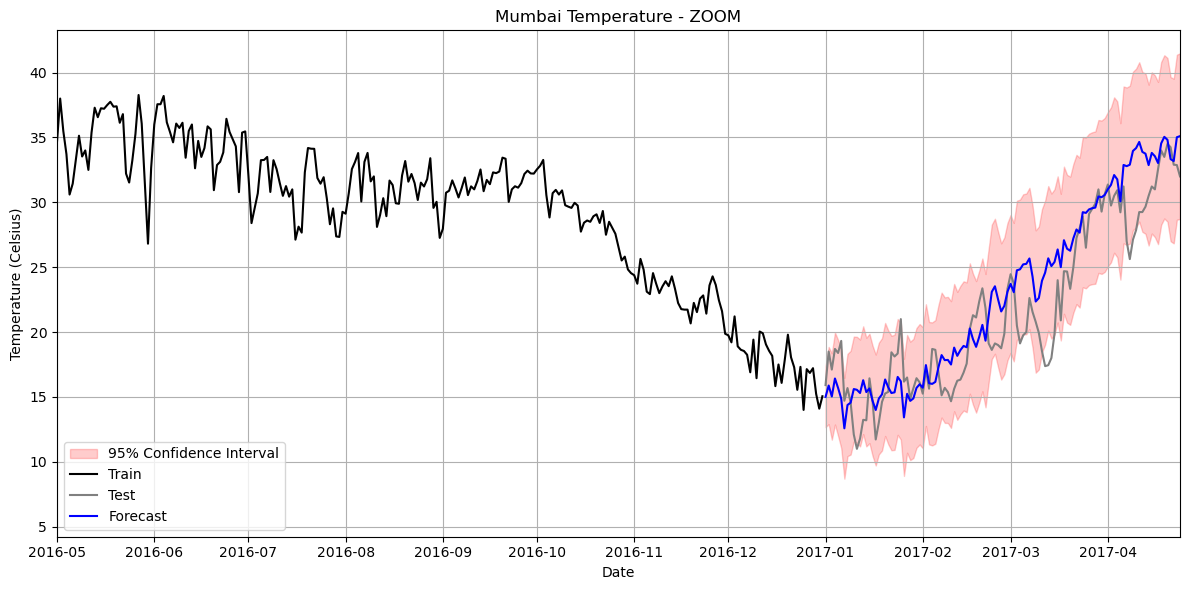

In [58]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2016-05-01'), pd.to_datetime('2017-04-24'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=3)                                             
plt.tight_layout()                                       
plt.show();

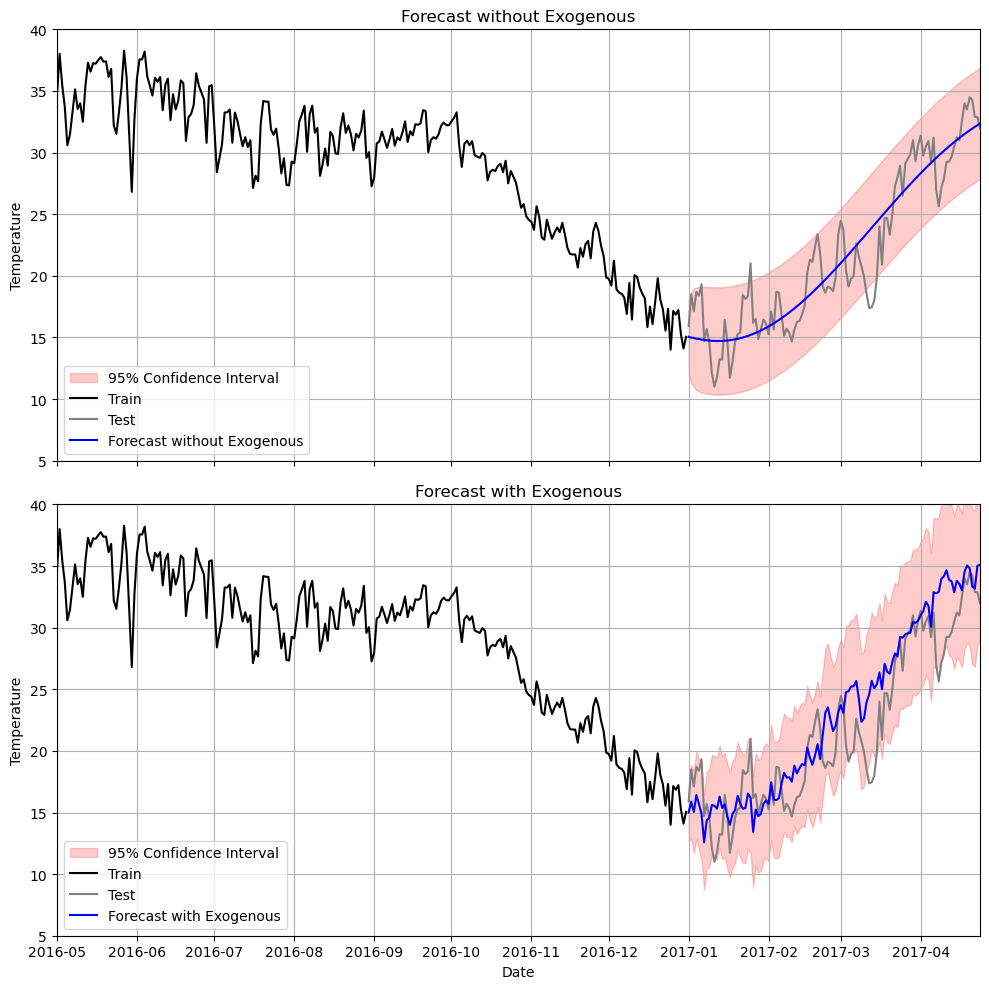

In [59]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['temp'], label='Train', color='black')
axes[0].plot(test.index, test['temp'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Temperature')
axes[0].legend(loc=3)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2016-05-01'), pd.to_datetime('2017-04-24'))
axes[0].set_ylim(5, 40)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['temp'], label='Train', color='black')
axes[1].plot(test.index, test['temp'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].legend(loc=3)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2016-05-01'), pd.to_datetime('2017-04-24'))
axes[1].set_ylim(5, 40)

# Final layout
plt.tight_layout()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['temp'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['temp'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['temp'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['temp'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

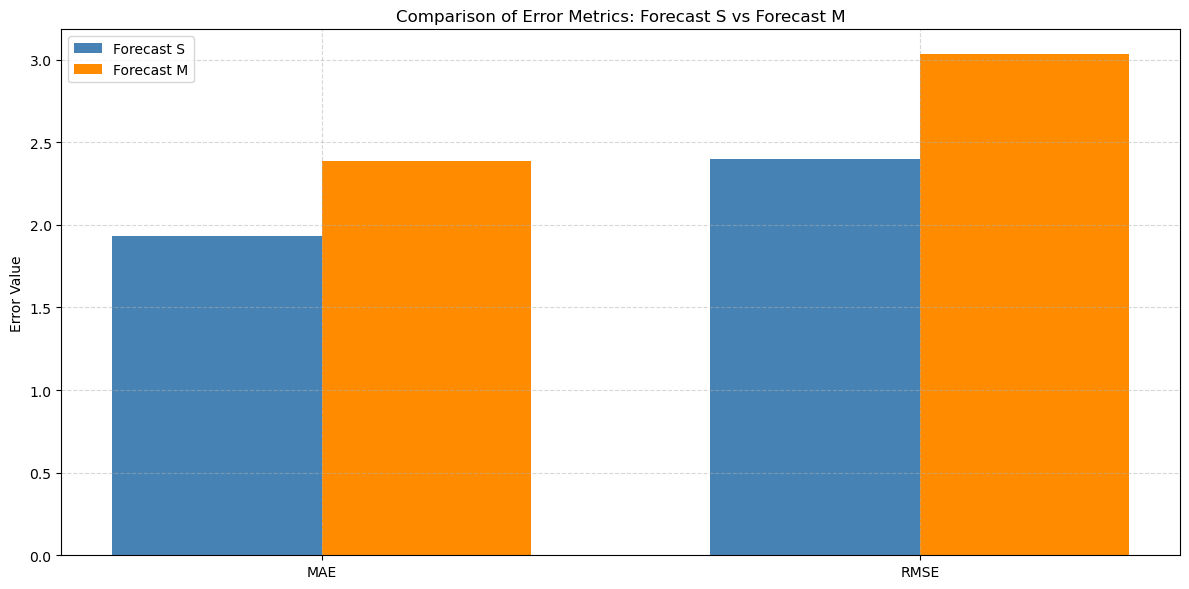

In [61]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [62]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,1.93,2.39
RMSE,2.40,3.03


In [63]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Create DataFrame for Error Analysis
comparison_mape = pd.DataFrame([mape_s, mape_m], index=['MAPE S', 'MAPE M']).T.round(2) 
comparison_mape

,MAPE S,MAPE M
0,9.67,12.14


In [64]:
# Model with only Fourier Transformation as exogenous variable had better results
accuracy1 = 100 - mape_s
accuracy2 = 100 - mape_m

print(f"  Accuracy for Fourier Tranformation model (based on MAPE): {accuracy1:.2f}%")
print(f"Accuracy for all exogenous variables model (based on MAPE): {accuracy2:.2f}%")

  Accuracy for Fourier Tranformation model (based on MAPE): 90.33%
Accuracy for all exogenous variables model (based on MAPE): 87.86%


End.

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Configuration
order = (1, 1, 1)
seasonal_order = (0, 0, 0, 365)

# Helper function to fit model and evaluate
def fit_and_evaluate(endog_train, endog_test, exog_train=None, exog_test=None):
    model = SARIMAX(endog_train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=len(endog_test), exog=exog_test)
    pred = forecast.predicted_mean

    mae = mean_absolute_error(endog_test, pred)
    rmse = np.sqrt(mean_squared_error(endog_test, pred))
    aic = model_fit.aic

    return mae, rmse, aic

# Model 1: wind_speed only
mae_ws, rmse_ws, aic_ws = fit_and_evaluate(train['temp'], test['temp'],
                                           exog_train=train[['wind_speed','Fourier']],
                                           exog_test=test[['wind_speed','Fourier']])

# Model 2: humidity only
mae_h, rmse_h, aic_h = fit_and_evaluate(train['temp'], test['temp'],
                                        exog_train=train[['humidity','Fourier']],
                                        exog_test=test[['humidity','Fourier']])

# Model 3: both
mae_both, rmse_both, aic_both = fit_and_evaluate(train['temp'], test['temp'],
                                                 exog_train=train[['wind_speed', 'humidity','Fourier']],
                                                 exog_test=test[['wind_speed', 'humidity','Fourier']])

# Compile results
comparison_df = pd.DataFrame({
    'Model': ['Wind Speed Only', 'Humidity Only', 'Wind Speed + Humidity'],
    'MAE': [mae_ws, mae_h, mae_both],
    'RMSE': [rmse_ws, rmse_h, rmse_both],
    'AIC': [aic_ws, aic_h, aic_both]
})

comparison_df

,Model,MAE,RMSE,AIC
0,Wind Speed Only,1.940332,2.403159,5404.419822
1,Humidity Only,2.383370,3.019480,4672.198841
2,Wind Speed + Humidity,2.389729,3.032160,4658.037754


In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Configuration
order = (1, 1, 1)
seasonal_order = (0, 0, 0, 365)

# Helper function to fit model and evaluate
def fit_and_evaluate(endog_train, endog_test, exog_train=None, exog_test=None):
    model = SARIMAX(endog_train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=len(endog_test), exog=exog_test)
    pred = forecast.predicted_mean

    mae = mean_absolute_error(endog_test, pred)
    rmse = np.sqrt(mean_squared_error(endog_test, pred))
    aic = model_fit.aic

    return mae, rmse, aic

# Model 0: Fourier only
mae_00, rmse_00, aic_00 = fit_and_evaluate(train['temp'], test['temp'],
                                           exog_train=train[['Fourier']],
                                           exog_test=test[['Fourier']])

# Model 1: wind_speed and Fourier
mae_ws, rmse_ws, aic_ws = fit_and_evaluate(train['temp'], test['temp'],
                                           exog_train=train[['wind_speed','Fourier']],
                                           exog_test=test[['wind_speed','Fourier']])

# Model 2: humidity and Fourier
mae_h, rmse_h, aic_h = fit_and_evaluate(train['temp'], test['temp'],
                                        exog_train=train[['humidity','Fourier']],
                                        exog_test=test[['humidity','Fourier']])

# Model 3: wind_speed, humidity, and Fourier
mae_both, rmse_both, aic_both = fit_and_evaluate(train['temp'], test['temp'],
                                                 exog_train=train[['wind_speed', 'humidity','Fourier']],
                                                 exog_test=test[['wind_speed', 'humidity','Fourier']])

# Compile results
comparison_df = pd.DataFrame({
    'Model': ['Fourier Only' ,'Wind Speed + Fourier', 'Humidity + Fourier', 'Wind Speed + Humidity + Fourier'],
    'MAE': [mae_00, mae_ws, mae_h, mae_both],
    'RMSE': [rmse_00, rmse_ws, rmse_h, rmse_both],
    'AIC': [aic_00, aic_ws, aic_h, aic_both]
})

# Set index
comparison_df.set_index('Model', inplace=True)
comparison_df

,MAE,RMSE,AIC
Model,,,
Fourier Only,1.931869,2.395992,5409.371143
Wind Speed + Fourier,1.940332,2.403159,5404.419822
Humidity + Fourier,2.383370,3.019480,4672.198841
Wind Speed + Humidity + Fourier,2.389729,3.032160,4658.037754


### Practical Decision

| Scenario | Best Choice | Justification |
|----------|-------------|---------------|
| If the focus is on simplicity and short-term forecasting with minimal absolute error | Fourier Only | Best MAE and RMSE, simplest model |
| If the focus is on a robust model with a better trade-off between fit and complexity (e.g., production, medium to long term) | Wind + Humidity + Fourier | Best AIC (model selection criterion) |